In [10]:
import os
import argparse
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import string

In [2]:
# Параметры
IMG_HEIGHT = 64         # Высота изображения
IMG_WIDTH = 256         # Ширина изображения
BATCH_SIZE = 4
MAX_LABEL_LENGTH = 15   # Максимальная длина текста
MARGIN = 0            # Отступ вокруг текста
BG_COLOR = 'white'      # Цвет фона
TEXT_COLOR = 'black'    # Цвет текста

# Пути к директориям
FONT_DIR = 'text/fonts/'
TEXT_FILE = 'text/sah.wordlist'
OUTPUT_IMAGE_DIR = 'test_images/images'
OUTPUT_LABEL_DIR = 'test_images/labels'
FONTS_LIST_FILE = 'text/okfonts_test.txt'

In [3]:
def load_texts(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    return lines

texts = load_texts(TEXT_FILE)[:1000]
print(f"Всего слов для генерации: {len(texts)}")

Всего слов для генерации: 1000


In [4]:
with open(FONTS_LIST_FILE, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]
    
fonts = []

for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(FONT_DIR, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                fonts.append(font_path)

print(f"Количество найденных файлов шрифтов: {len(fonts)}")

Количество найденных файлов шрифтов: 75


In [27]:
# Генерация Изображений и Меток
def create_image(text, font_path, img_height, img_width, margin, bg_color, text_color):
    try:
        font_size = 32  # Начальный размер шрифта
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Не удалось загрузить шрифт: {font_path}")
        return None

    # Создаём изображение с фоном
    image = Image.new('RGB', (img_width, img_height), color=bg_color)
    draw = ImageDraw.Draw(image)

    # Автоматически подбираем размер шрифта
    while True:
        # Используем textbbox вместо textsize
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        if text_width + 2 * margin < img_width and text_height + 2 * margin < img_height:
            break
        font_size -= 1
        if font_size <= 10:
            break
        try:
            font = ImageFont.truetype(font_path, font_size)
        except IOError:
            print(f"Не удалось загрузить шрифт: {font_path} с размером {font_size}")
            return None

    # Позиционирование текста по центру
    x = (img_width - text_width) / 2
    y = (img_height - text_height) / 2

    draw.text((x, y), text, font=font, fill=text_color)

    # Преобразуем в массив NumPy
    image = np.array(image)

    # Дополнительная обработка (например, бинаризация)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)

    return image

In [28]:
# Генерация изображений и меток
for font_path in tqdm(fonts, desc="Шрифты"):
    font_name = os.path.splitext(os.path.basename(font_path))[0]
    for idx, line in enumerate(tqdm(texts, desc=f"Генерация для шрифта {font_name}", leave=False)):
        # Создаём изображение
        image = create_image(
            text=line,
            font_path=font_path,
            img_height=IMG_HEIGHT,
            img_width=IMG_WIDTH,
            margin=MARGIN,
            bg_color=BG_COLOR,
            text_color=TEXT_COLOR
        )
        if image is None:
            continue

        # Формируем имена файлов
        image_filename = f"img_{font_name}_{idx}.png"
        label_filename = f"img_{font_name}_{idx}.txt"

        # Сохраняем изображение
        image_path = os.path.join(OUTPUT_IMAGE_DIR, image_filename)
        cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        # Сохраняем метку
        label_path = os.path.join(OUTPUT_LABEL_DIR, label_filename)
        with open(label_path, 'w', encoding='utf-8') as label_file:
            label_file.write(line)

print("Генерация датасета завершена.")

Шрифты:  17%|█▋        | 13/75 [00:55<04:22,  4.23s/it]                                      
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   0%|          | 0/1000 [00:00<?, ?it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   3%|▎         | 31/1000 [00:00<00:03, 307.88it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   6%|▌         | 62/1000 [00:00<00:03, 288.36it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   9%|▉         | 91/1000 [00:00<00:03, 252.13it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  12%|█▏        | 117/1000 [00:00<00:03, 226.17it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  14%|█▍        | 141/1000 [00:00<00:04, 195.43it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  16%|█▌        | 162/1000 [00:00<00:04, 184.53it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  18%|█▊        | 181/1000 [00:00<00:04, 177.49it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  20%|██        | 202/1000 [00:00<00:04, 185.8

Генерация датасета завершена.


In [5]:
import glob
from sklearn.model_selection import train_test_split

In [6]:
# Создание списков путей к изображениям и меткам
def get_image_label_pairs(image_dir, label_dir):
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
    label_files = sorted(glob.glob(os.path.join(label_dir, '*.txt')))
    image_label_pairs = []
    for img_path, lbl_path in zip(image_files, label_files):
        with open(lbl_path, 'r', encoding='utf-8') as f:
            label = f.read().strip()
        image_label_pairs.append((img_path, label))
    return image_label_pairs

In [7]:
image_label_pairs = get_image_label_pairs(OUTPUT_IMAGE_DIR, OUTPUT_LABEL_DIR)
print(f"Всего пар изображение-метка: {len(image_label_pairs)}")
# Ожидаемый вывод: Всего пар изображение-метка: 1000 * количество шрифтов

# Разделение данных на обучающую, валидационную и тестовую выборки
train_pairs, temp_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

print(f"Train: {len(train_pairs)}, Validation: {len(val_pairs)}, Test: {len(test_pairs)}")

Всего пар изображение-метка: 75000
Train: 60000, Validation: 7500, Test: 7500


In [18]:
def preprocess_image(image_path, img_height, img_width):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0  # Нормализация
    return img.astype(np.float32)

def encode_sample(image_path, label):
    # Декодируем image_path из байтов в строку
    image_path = image_path.numpy().decode('utf-8')
    
    # Декодируем label из байтов в строку
    label = label.numpy().decode('utf-8')
    
    # Обрабатываем изображение
    img = preprocess_image(image_path, IMG_HEIGHT, IMG_WIDTH)
    
    # Преобразуем текст в числовые метки
    label = text_to_labels(label)
    
    # Обрезаем и дополняем метку до MAX_LABEL_LENGTH
    label = label[:MAX_LABEL_LENGTH]
    label += [0] * (MAX_LABEL_LENGTH - len(label))
    
    return img, label

def tf_encode(image_path, label):
    img, label = tf.py_function(func=encode_sample, inp=[image_path, label], Tout=[tf.float32, tf.int32])
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    label.set_shape([None])
    return img, label

def prepare_dataset(pairs):
    image_paths, labels = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [19]:
# Подготовка Словаря Символов
characters = string.ascii_letters + string.digits + 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһүАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯҔҤӨҺҮ '

# Создание маппинга символов в числа и обратно
char_to_num = {char: idx + 1 for idx, char in enumerate(characters)}  # 0 для CTC blank
num_to_char = {idx + 1: char for idx, char in enumerate(characters)}

def text_to_labels(text):
    return [char_to_num[char] for char in text if char in char_to_num]

def labels_to_text(labels):
    return ''.join([num_to_char[label] for label in labels if label in num_to_char])

In [20]:
train_dataset = prepare_dataset(train_pairs)
val_dataset = prepare_dataset(val_pairs)
test_dataset = prepare_dataset(test_pairs)

In [21]:
# def prepare_batch(images, labels):
#     # Паддинг меток до максимальной длины
#     labels = pad_sequences(labels, maxlen=MAX_LABEL_LENGTH, padding='post', value=0)
#     label_length = tf.math.count_nonzero(labels, axis=1)
#     input_length = tf.ones(shape=(tf.shape(labels)[0],), dtype=tf.int32) * (IMG_WIDTH // 4)  # Примерное значение, зависит от модели
#     return {
#         "input_image": images,
#         "labels": labels,
#         "input_length": input_length,
#         "label_length": label_length
#     }, None

def prepare_batch(images, labels):
    label_length = tf.math.count_nonzero(labels, axis=1)
    input_length = tf.ones(shape=(tf.shape(labels)[0],), dtype=tf.int32) * (IMG_WIDTH // 4)  # Примерное значение, зависит от модели
    return {
        "input_image": images,
        "labels": labels,
        "input_length": input_length,
        "label_length": label_length
    }, None

In [22]:
# Применение batch, map и prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

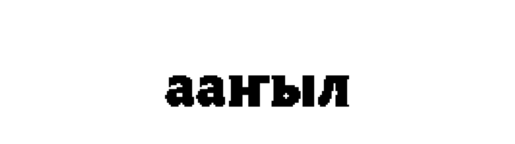

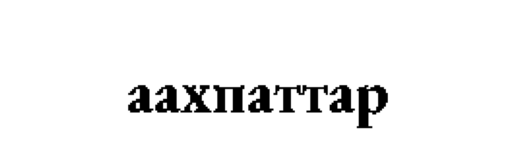

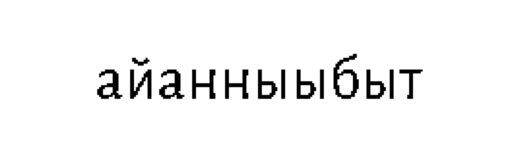

In [33]:
def display_samples(dataset, num_samples=5):
    for batch in dataset.take(1):
        inputs, _ = batch
        images = inputs['input_image'].numpy()
        labels = inputs['labels'].numpy()
        for i in range(min(num_samples, images.shape[0])):
            plt.imshow(images[i])
            plt.axis('off')
            plt.show()

# Визуализация обучающей выборки
display_samples(train_dataset, num_samples=3)